# Protein-protein complex conformational space exploration (CSE) using basins trajectories and a Transformer Neural Network 

**Packages required:**
    
* MDAnalysis
* MDAnalysisData
* matplotlib
* numpy
* sklearn
* tensorflow
* Bio
* nglview
* pytraj

In [4]:
import warnings
# avoid excessive warning messages to make the notebook nicer
warnings.filterwarnings('ignore')
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import subprocess
import random
import MDAnalysis as mda
#from MDAnalysis.tests.datafiles import GRO, XTC
from MDAnalysis.analysis import dihedrals, rms, align
import MDAnalysisData as mda_data
from MDAnalysisData import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import savetxt,loadtxt
import sklearn as skl
from sklearn import cluster, mixture
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Layer,Dropout,Dense,Bidirectional
from tensorflow.keras.layers import GRU,LSTM,Embedding,MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization,Conv1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, model_from_json, load_model, clone_model
from tensorflow.python.client import device_lib
import nglview as nv
import Bio as bio
from Bio.SeqUtils import seq1, seq3
from itertools import chain, islice
import pytraj as pt
import h5py

import modeller as modl
from modeller import *
from modeller.automodel import *    # Load the AutoModel class
from modeller.scripts import complete_pdb
from modeller.optimizers import conjugate_gradients, molecular_dynamics, actions

print("mda version = {}".format(mda.__version__))
print("mda data version = {}".format(mda_data.__version__))
print("plt version = {}".format(matplotlib.__version__))
print("np version = {}".format(np.__version__))
print("skl version = {}".format(skl.__version__))
print("tf version = {}".format(tf.__version__))
print("bio version = {}".format(bio.__version__))
print("nglview version = {}".format(nv.__version__))
print("pytraj version = {}".format(pt.__version__))
print("modeller version = {}\n".format(modl.__version__))

%matplotlib inline
%load_ext autoreload
%autoreload 2

mda version = 2.1.0
mda data version = 0.8.1
plt version = 3.2.2
np version = 1.21.6
skl version = 1.0.2
tf version = 2.8.0
bio version = 1.79
nglview version = 3.0.3
pytraj version = 2.0.5
modeller version = 10.2



## Loading files

### Equilibrium PPI trajectory

In [6]:
# adk = datasets.fetch_adk_equilibrium()

# print(adk.DESCR)
# print(adk.topology)
# print(adk.trajectory)

In [7]:
# u_equil = mda.Universe(adk.topology, adk.trajectory)

# n_frames = len(u_equil.trajectory)
# print(f'There are {n_frames} frames in the trajectory')

# # Atom selection
# protein = u_equil.select_atoms('protein')
# print(f'There are {len(protein.residues)} protein residues in each frame')

### Multiple PPI transition trajectories 

In [8]:
import glob
#ppi_trans = datasets.fetch_adk_transitions_DIMS()
#ppi_trans.trajectories = glob.glob(os.path.join("/home/jmwang/WorkSpace/MDGM/train_data/trajectories",'*'))

ppi_trajectories = glob.glob(os.path.join("/home/jmwang/WorkSpace/MDGM/train_data/trajectories",'*'))

In [9]:
#ppi_trans.topology="/home/jmwang/WorkSpace/MDGM/train_data/topolog/ppcomplex_solv.prmtop"
ppi_topology="/home/jmwang/WorkSpace/MDGM/train_data/topolog/ppcomplex.pdb"
print(ppi_trajectories)
print(ppi_topology) 

['/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein2_6.dcd', '/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein2_14.dcd', '/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein10_2.dcd', '/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein4_4.dcd', '/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein11_5.dcd', '/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein2_7.dcd', '/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein7_13.dcd', '/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein1_17.dcd', '/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein11_2.dcd', '/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein10_17.dcd', '/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein2_10.dcd', '/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein3_10.dcd', '/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein10_18.dcd', '/home/jmwang/WorkSpace/MDGM/train_data/trajectories/protein6_11.dcd', '/home

In [10]:
# Here we examine the entire ensemble of trajectories 
n_trj = len(ppi_trajectories)
all_trj_nframes = []

for i,trajectory in enumerate(ppi_trajectories):
    u = mda.Universe(ppi_topology, trajectory)
    single_trj_nframes = len(u.trajectory)
    all_trj_nframes.append(single_trj_nframes)

all_trj_nframes = np.array(all_trj_nframes)

print(f'Number of trajectories in the ensemble: {n_trj}')
print(f'Number of frames in each trajectory of the ensemble:')
print(*all_trj_nframes,'\n')

Number of trajectories in the ensemble: 308
Number of frames in each trajectory of the ensemble:
500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500 500

### Validation set

In [11]:
# Here we select the first two trajectories of the ensemble as the validation and test sets, respectively. 
# Later on we will loop through the other trajectories to train the NN.
u_val = mda.Universe(ppi_topology, ppi_trajectories[0])
print(f'Number of frames in the validation set: {len(u_val.trajectory)}')
u_test = mda.Universe(ppi_topology, ppi_trajectories[1])
print(f'Number of frames in the test set: {len(u_test.trajectory)}')

Number of frames in the validation set: 500
Number of frames in the test set: 500


In [12]:
# Here we use the validation set to view the conformational transition 
view = nv.show_mdanalysis(u_val)
view.center()
view

NGLWidget(max_frame=499)

In [13]:
# Here we use the validation set to get information about the protein
#protein A
n_frames = len(u_val.trajectory)
print(f'There are {n_frames} frames in the trajectory')

# Atom selection
proteinA = u_val.select_atoms('resid 1:85')
print(f'There are {len(proteinA.residues)} protein residues in each frame')

There are 500 frames in the trajectory
There are 85 protein residues in each frame


In [14]:
# Here we use the validation set to get information about the protein
#protein B
n_frames = len(u_val.trajectory)
print(f'There are {n_frames} frames in the trajectory')

# Atom selection
proteinB = u_val.select_atoms('resid 86:98')
print(f'There are {len(proteinB.residues)} protein residues in each frame')

There are 500 frames in the trajectory
There are 13 protein residues in each frame


In [15]:
# Here we use the validation set to get information about the protein
#protein
n_frames = len(u_val.trajectory)
print(f'There are {n_frames} frames in the trajectory')

# Atom selection
protein = u_val.select_atoms('protein')
print(f'There are {len(protein.residues)} protein residues in each frame')

There are 500 frames in the trajectory
There are 98 protein residues in each frame


In [16]:
# Protein sequence in 3 letter code
#protein A
prot_sequence_tlc = ''
for res in chain.from_iterable(proteinA.residues.resnames):
    prot_sequence_tlc += res
print(f'Protein A sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc_A = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc_A.append(prot_sequence_tlc[index : index + n])
print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc_A}\n')

# Protein sequence in 3 letter code
prot_sequence_slc = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc}')

Protein A sequence in 3 letter code:
GLUTHRLEUVALARGPROLYSPROLEULEULEULYSLEULEULYSSERVALGLYALAGLNLYSASPTHRTYRTHRMETLYSGLUVALLEUPHETYRLEUGLYGLNTYRILEMETTHRLYSARGLEUTYRASPGLULYSGLNGLNHIEILEVALTYRCYSSERASNASPLEULEUGLYASPLEUPHEGLYVALPROSERPHESERVALLYSGLUHIEARGLYSILETYRTHRMETILETYRARGASNLEUVALVAL

Protein sequence in split 3 letter code:
['GLU', 'THR', 'LEU', 'VAL', 'ARG', 'PRO', 'LYS', 'PRO', 'LEU', 'LEU', 'LEU', 'LYS', 'LEU', 'LEU', 'LYS', 'SER', 'VAL', 'GLY', 'ALA', 'GLN', 'LYS', 'ASP', 'THR', 'TYR', 'THR', 'MET', 'LYS', 'GLU', 'VAL', 'LEU', 'PHE', 'TYR', 'LEU', 'GLY', 'GLN', 'TYR', 'ILE', 'MET', 'THR', 'LYS', 'ARG', 'LEU', 'TYR', 'ASP', 'GLU', 'LYS', 'GLN', 'GLN', 'HIE', 'ILE', 'VAL', 'TYR', 'CYS', 'SER', 'ASN', 'ASP', 'LEU', 'LEU', 'GLY', 'ASP', 'LEU', 'PHE', 'GLY', 'VAL', 'PRO', 'SER', 'PHE', 'SER', 'VAL', 'LYS', 'GLU', 'HIE', 'ARG', 'LYS', 'ILE', 'TYR', 'THR', 'MET', 'ILE', 'TYR', 'ARG', 'ASN', 'LEU', 'VAL', 'VAL']

Protein sequence in 1 letter code:
ETLVRPKPLLLKLLKSVGAQKDTYTMKEVLFYL

In [17]:
# Protein sequence in 3 letter code
#protein B
prot_sequence_tlc = ''
for res in chain.from_iterable(proteinB.residues.resnames):
    prot_sequence_tlc += res
print(f'Protein B sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc_B = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc_B.append(prot_sequence_tlc[index : index + n])
print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc_B}\n')

# Protein sequence in 3 letter code
prot_sequence_slc = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc}')

Protein B sequence in 3 letter code:
GLUTHRPHESERASPLEUTRPLYSLEULEUPROGLUASN

Protein sequence in split 3 letter code:
['GLU', 'THR', 'PHE', 'SER', 'ASP', 'LEU', 'TRP', 'LYS', 'LEU', 'LEU', 'PRO', 'GLU', 'ASN']

Protein sequence in 1 letter code:
ETFSDLWKLLPEN


In [18]:
# Protein sequence in 3 letter code
#protein complex
prot_sequence_tlc = ''
for res in chain.from_iterable(protein.residues.resnames):
    prot_sequence_tlc += res
print(f'Protein sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc.append(prot_sequence_tlc[index : index + n])
print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc}\n')

# Protein sequence in 3 letter code
prot_sequence_slc = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc}')

Protein sequence in 3 letter code:
GLUTHRLEUVALARGPROLYSPROLEULEULEULYSLEULEULYSSERVALGLYALAGLNLYSASPTHRTYRTHRMETLYSGLUVALLEUPHETYRLEUGLYGLNTYRILEMETTHRLYSARGLEUTYRASPGLULYSGLNGLNHIEILEVALTYRCYSSERASNASPLEULEUGLYASPLEUPHEGLYVALPROSERPHESERVALLYSGLUHIEARGLYSILETYRTHRMETILETYRARGASNLEUVALVALGLUTHRPHESERASPLEUTRPLYSLEULEUPROGLUASN

Protein sequence in split 3 letter code:
['GLU', 'THR', 'LEU', 'VAL', 'ARG', 'PRO', 'LYS', 'PRO', 'LEU', 'LEU', 'LEU', 'LYS', 'LEU', 'LEU', 'LYS', 'SER', 'VAL', 'GLY', 'ALA', 'GLN', 'LYS', 'ASP', 'THR', 'TYR', 'THR', 'MET', 'LYS', 'GLU', 'VAL', 'LEU', 'PHE', 'TYR', 'LEU', 'GLY', 'GLN', 'TYR', 'ILE', 'MET', 'THR', 'LYS', 'ARG', 'LEU', 'TYR', 'ASP', 'GLU', 'LYS', 'GLN', 'GLN', 'HIE', 'ILE', 'VAL', 'TYR', 'CYS', 'SER', 'ASN', 'ASP', 'LEU', 'LEU', 'GLY', 'ASP', 'LEU', 'PHE', 'GLY', 'VAL', 'PRO', 'SER', 'PHE', 'SER', 'VAL', 'LYS', 'GLU', 'HIE', 'ARG', 'LYS', 'ILE', 'TYR', 'THR', 'MET', 'ILE', 'TYR', 'ARG', 'ASN', 'LEU', 'VAL', 'VAL', 'GLU', 'THR', 'PHE', 'SER', 'ASP

In [19]:
# function to get unique values in a list
def unique(list): 
    unique_list = []
    for x in list:
        if x not in unique_list:
            unique_list.append(x)        
    return unique_list

In [20]:
# Unique amino acids in the protein 
unique_aa = unique(split_prot_sequence_tlc)
print(len(split_prot_sequence_tlc),unique_aa)

# Table used to convert each type of aa into a number
aa_to_number_table = []
split_prot_sequence_as_type = np.zeros((98,))
for i,aa in enumerate(unique_aa):
    aa_to_number_table.append((aa,i))
#     print(aa)
    ind = [res == aa for res in split_prot_sequence_tlc]
    split_prot_sequence_as_type[ind] = i

# Protein sequence as numbers corresponding to different aa's 
# (used later on in the PosEmbedding function)
split_prot_sequence_as_type = split_prot_sequence_as_type.astype('int32').tolist()    
print(f'AA to NUMBER table:\n{aa_to_number_table}\n')
print(f'Protein sequence as aa type:\n{split_prot_sequence_as_type}')

98 ['GLU', 'THR', 'LEU', 'VAL', 'ARG', 'PRO', 'LYS', 'SER', 'GLY', 'ALA', 'GLN', 'ASP', 'TYR', 'MET', 'PHE', 'ILE', 'HIE', 'CYS', 'ASN', 'TRP']
AA to NUMBER table:
[('GLU', 0), ('THR', 1), ('LEU', 2), ('VAL', 3), ('ARG', 4), ('PRO', 5), ('LYS', 6), ('SER', 7), ('GLY', 8), ('ALA', 9), ('GLN', 10), ('ASP', 11), ('TYR', 12), ('MET', 13), ('PHE', 14), ('ILE', 15), ('HIE', 16), ('CYS', 17), ('ASN', 18), ('TRP', 19)]

Protein sequence as aa type:
[0, 1, 2, 3, 4, 5, 6, 5, 2, 2, 2, 6, 2, 2, 6, 7, 3, 8, 9, 10, 6, 11, 1, 12, 1, 13, 6, 0, 3, 2, 14, 12, 2, 8, 10, 12, 15, 13, 1, 6, 4, 2, 12, 11, 0, 6, 10, 10, 16, 15, 3, 12, 17, 7, 18, 11, 2, 2, 8, 11, 2, 14, 8, 3, 5, 7, 14, 7, 3, 6, 0, 16, 4, 6, 15, 12, 1, 13, 15, 12, 4, 18, 2, 3, 3, 0, 1, 14, 7, 11, 2, 19, 6, 2, 2, 5, 0, 18]


In [21]:
aa_to_number_dict = {}
for i in aa_to_number_table:
    aa_to_number_dict[i[0]]=i[1]

print(aa_to_number_dict)

split_prot_sequence_tlc_A_id = [aa_to_number_dict[i] for i in split_prot_sequence_tlc_A]
split_prot_sequence_tlc_A_id = np.array(split_prot_sequence_tlc_A_id).astype('int32').tolist() 
split_prot_sequence_tlc_A_id 

split_prot_sequence_tlc_B_id = [aa_to_number_dict[i] for i in split_prot_sequence_tlc_B]
split_prot_sequence_tlc_B_id = np.array(split_prot_sequence_tlc_B_id).astype('int32').tolist() 
split_prot_sequence_tlc_A_id[:5],split_prot_sequence_tlc_B_id

{'GLU': 0, 'THR': 1, 'LEU': 2, 'VAL': 3, 'ARG': 4, 'PRO': 5, 'LYS': 6, 'SER': 7, 'GLY': 8, 'ALA': 9, 'GLN': 10, 'ASP': 11, 'TYR': 12, 'MET': 13, 'PHE': 14, 'ILE': 15, 'HIE': 16, 'CYS': 17, 'ASN': 18, 'TRP': 19}


([0, 1, 2, 3, 4], [0, 1, 14, 7, 11, 2, 19, 6, 2, 2, 5, 0, 18])

## Ramachandran analysis

The `Ramachandran` class calculates the $\phi$ and $\psi$ angles of the selected residues over the course of a trajectory, saving it into `results.angles`. If residues are given that do not contain a $\phi$ and $\psi$ angle, they are omitted from the results. For example, the angles returned are from every residue in the protein *except* the first and last, for which a $\phi$ angle and a $\psi$ angle do not exist, respectively.

<img src="dihedral.png" style="width:400px;height:200px;">

The returned `results.angles` are in the shape (`n_frames`, `n_residues`, 2) where the last dimension holds the $\phi$ and $\psi$ angle.

`Ramachandran.plot()` plots the data from each time step onto a standard Ramachandran plot. Any keyword arguments (except `ax` and `ref`) are passed to `matplotlib.axes.Axes.scatter` to modify the plot. Setting `ref=True`, plots areas that show the allowed (dark blue) and marginally allowed (lighter blue) regions.

Ramachandran angles array shape: (500, 96, 2)


array([[[ -79.85247624,  112.54390074],
        [ -83.71543383,  138.95377638],
        [-132.1770987 ,  148.63325241],
        ...,
        [ -53.88070266,  149.9914468 ],
        [ -70.796966  ,  153.96879303],
        [ -87.67135052,  -14.98316708]],

       [[ -89.76021955,   95.95190448],
        [ -78.14821227,  141.88612966],
        [-143.94653691,  145.1235084 ],
        ...,
        [ -67.00903193,  143.7049062 ],
        [ -77.32175391,  153.41589191],
        [ -85.6137372 ,  -40.80917225]],

       [[-117.70114172,  104.58617114],
        [ -90.72232735,  123.78497461],
        [-130.29586919,  140.11380849],
        ...,
        [ -67.4962911 ,  140.37633929],
        [ -72.97758164,  156.18787096],
        [ -96.02618227,  -31.98619426]],

       ...,

       [[ -77.70492481,  112.9438732 ],
        [-111.33637691,  121.885208  ],
        [-136.48528377,  153.32953872],
        ...,
        [ -62.06005386,  132.75092038],
        [ -92.17743471,  164.52428613],
        [

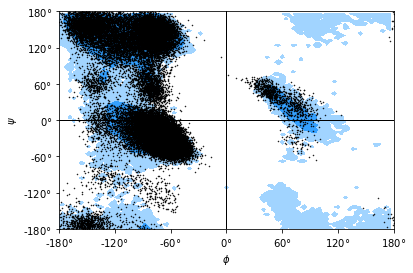

In [22]:
# Ramachandran angles for all the residues in protein. 
# To select a range of frames use .run(startframe,endframe+1)
# The 'protein' selection still refers here to the validation trj
rama = dihedrals.Ramachandran(protein).run()
rama.plot(color='black', marker='.', s=1, ref=True)
trj_phipsi = rama.results.angles
print(f'Ramachandran angles array shape: {trj_phipsi.shape}')
trj_phipsi

### Conversion of the trajectory into a lists of 4 symbols/frame.

Using simple selection of 4 attraction basins may ignore the actual distributions of angles during the dynamic. The function phipsi_to_basin offers the option to cluster the angles by k-means. We can shift the phi angles in order to obtain a better selection of basins.

In [23]:
def phipsi_to_basin(angles,phi_shift=-120.,cluster=False,n_clusters=4,plot=True):
    
    # Here, we reshape the sequence of frames so that the entire trajectory fits into 
    # a single 2D array for clustering
    shapes = angles.shape
    angles = np.reshape(angles,(shapes[0]*shapes[1],shapes[2]),order='C')

    # Shift in phi angles to obtain clean basins
    for value in angles:
        if value[1]<phi_shift:
            value[1] += 360.    

    init_centroids = np.array([[-100.,150],[-100.,-50.],[100.,-50.],[100.,150.]])
    kmeans = KMeans(n_clusters, 
                    init=init_centroids,
                    random_state=123,
                    algorithm='full').fit(angles)
    centroids = kmeans.cluster_centers_
    # score = kmeans.score(angles)
    
    if cluster:
        preds = kmeans.labels_
    else:
        preds = []
        for phipsi in angles:
            if phipsi[0]<=25. and phipsi[1]>70.:
                preds.append(0)
            elif phipsi[0]<=25. and phipsi[1]<=70.:
                preds.append(1)
            elif phipsi[0]>25. and phipsi[1]<=70.:
                preds.append(2)
            elif phipsi[0]>25. and phipsi[1]>70:
                preds.append(3)
        preds = np.array(preds) 
        
    if plot:
        x = [phipsi[0] for phipsi in angles]
        y = [phipsi[1] for phipsi in angles]

        # The scatter plot has markers colored by the basin cluster
        fig, (ax1) = plt.subplots(1,1)
        fig.set_figheight(5)
        fig.set_figwidth(7)
        fig.suptitle('Ramachandran plot with Basins predictions')
        scatterplot = ax1.scatter(x,y,s=1,c=preds)
        ax1.set_xticklabels(['$-200^{\circ}$','$-150^{\circ}$','$-100^{\circ}$','$-50^{\circ}$',\
                             '$0^{\circ}$','$50^{\circ}$','$100^{\circ}$','$150^{\circ}$'],fontsize=13)
        ax1.set_yticklabels(['$-150^{\circ}$','$-100^{\circ}$','$-50^{\circ}$',\
                             '$0^{\circ}$','$50^{\circ}$','$100^{\circ}$',\
                             '$150^{\circ}$','$200^{\circ}$','$250^{\circ}$'],fontsize=13)
        ax1.set_ylabel("$\psi$",fontsize=14)
        ax1.set_xlabel("$\phi$",fontsize=14)
        ax1.grid()

        # produce a legend with the unique colors from the scatter
        legend = ax1.legend(*scatterplot.legend_elements(),
                            loc="best", title="Classes")
        ax1.add_artist(legend)
        ax1.legend()
                
    basins = np.reshape(preds,(shapes[0],shapes[1]))
    angles = np.reshape(angles,(shapes[0],shapes[1],shapes[2]))            
        
    return angles,basins,centroids

In [24]:
print(trj_phipsi.shape)

(500, 96, 2)


### Validation Basins datasets
First we use as validation set only the first trajectory to obtain a nice image of the clustering

No handles with labels found to put in legend.


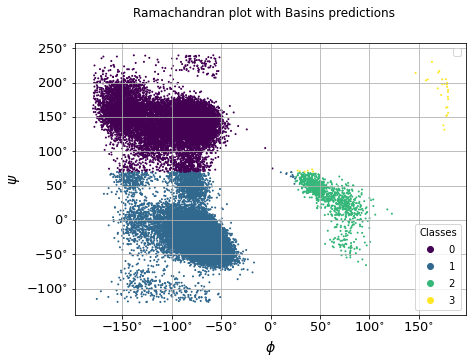

In [25]:
val_angles,val_basins,val_centroids = phipsi_to_basin(trj_phipsi,phi_shift=-120.,
                                                      cluster=False,
                                                      n_clusters=4,
                                                      plot=True)

In [26]:
print(val_basins.shape,val_angles.shape)

(500, 96) (500, 96, 2)


In [27]:
print(f'Ramachandran centroids\n {val_centroids}')
print(f'Basin trj dimensions: {val_basins.shape}')
print(f'Basin trj: {val_basins}')

Ramachandran centroids
 [[-105.6538527   140.47328877]
 [ -70.15544119  -29.72631206]
 [  76.63546093    7.64436906]
 [  52.54251446   54.1126937 ]]
Basin trj dimensions: (500, 96)
Basin trj: [[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [28]:
print(*val_basins[0])

0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1


In [29]:
print(*val_basins[-47])

0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1


In [30]:
print(*val_basins[-1])

0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1


#### Select a validation:test:training split at 20:20:60
In preparation for training we select a more traditional split between validation, test, and training set.

In [27]:
u_val = mda.Universe(ppi_topology, ppi_trajectories[0:1])
print(f'Number of frames in the validation set: {len(u_val.trajectory)}')
u_test = mda.Universe(ppi_topology, ppi_trajectories[2:3])
print(f'Number of frames in the test set: {len(u_test.trajectory)}')

Number of frames in the validation set: 500
Number of frames in the test set: 500


In [28]:
# Here we use the larger validation set to get information about the protein
n_frames = len(u_val.trajectory)
print(f'There are {n_frames} frames in the trajectory')

# Atom selection
protein = u_val.select_atoms('protein')
print(f'There are {len(protein.residues)} protein residues in each frame')

There are 500 frames in the trajectory
There are 98 protein residues in each frame


In [29]:
# Ramachandran angles for all the residues in protein. 
# To select a range of frames use .run(startframe,endframe+1)
# The 'protein' selection still refers here to the validation trj
rama = dihedrals.Ramachandran(protein).run()
# rama.plot(color='black', marker='.', s=1, ref=True)
trj_phipsi = rama.results.angles
print(f'Ramachandran angles array shape: {trj_phipsi.shape}')

Ramachandran angles array shape: (500, 96, 2)


In [30]:
val_angles,val_basins,val_centroids = phipsi_to_basin(trj_phipsi,phi_shift=-120.,
                                                      cluster=False,
                                                      n_clusters=4,
                                                      plot=False)

In [31]:
print(*val_angles[0])
val_centroids.shape

[-79.85247624 112.54390074] [-83.71543383 138.95377638] [-132.1770987   148.63325241] [-110.88532121  103.90178676] [-91.58368306 151.98487946] [-71.22905334 159.41369103] [-48.62003679 -40.51314125] [-86.35215056 -31.56076608] [-60.01829168 -44.14907587] [-63.4378401  -42.38340836] [-60.33491629 -39.24366863] [-76.21435677 -34.05335461] [-60.1457953  -57.28034917] [-51.37746039 -19.20597522] [-77.352283    -4.80184314] [-142.21590383   13.41114403] [-159.60007478  196.61527552] [-84.52045826 154.0413167 ] [-87.93196091  32.97405965] [-55.5754686  142.00801381] [-98.01721614 -15.29172624] [-143.00167995  107.93398352] [-87.72546889 168.59558833] [-75.54467131 165.33662207] [-80.2599471 -30.6629751] [-62.12080664 -33.68313803] [-62.28911135 -54.65275805] [-43.72032885 -50.09297503] [-56.71268437 -43.08787439] [-71.24636314 -38.71824542] [-70.89008559 -48.1183214 ] [-58.41767657 -43.45791311] [-59.19221545 -36.42834238] [-64.12860172 -27.21808353] [-62.22173749 -48.92243842] [-68.4868863

(4, 2)

In [32]:
print(*val_basins[300])

0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1


In [33]:
print(*val_basins[300])

0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1


In [34]:
print(*val_basins[300])

0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1


Looks good: we can now use the predictions to convert the trj into an array of frames 
with each frame being an array of 4 symbols, one for each basin of attraction. First and last residues do not have phi-psi angles, so we only have 212 basins for the 214 residues of Adk.

### Dataset serving batches of inputs and targets to the Transformer

Starting from the initial basins dataset, we eliminate consecutive identical  frames and create 3 new datasets each with different padding:
* an input dataset for the encoder with final padding [6 6 6]
* an input dataset for the decoder with initial padding [4] (where 4 is the 'sequence start' signal) and final padding [5 6] (where 5 is the 'sequence end' signal). 
* a target dataset for the transformer with final padding [5 6 6]

The encoder input is the last know frame. The decoder input is the same sequence as the transformer target (the next frame to predict). However they are padded in a different way, as the decoder input must start from a generic 'sequence start' signal (in this case, number 4) to predict the 1st basin of the target, and stop predicting when it encounters a 'sequence end' signal (in this case, number 5). 


In [31]:
# Function to eliminate consecutive identical frames or 
# to skip frames in the basin trajectory
def reduce_basins(basins,ncycles,nskip):

    if ncycles == 0 and nskip > 1:
        trj = np.copy(basins)
        reduced_basins = np.array(trj[0::nskip,:])
    elif ncycles > 0 and nskip == 0:
        red_cycles = ncycles
        trj = np.copy(basins)

        for red_cycle in range(red_cycles):

            first_frame = np.array([trj[0]])
            # print(first_frame.shape,type(first_frame))

            count = 0
            reduced_trj = np.copy(first_frame)
            for i,frame in enumerate(trj):
                frame = np.array([frame])

                if i == 0:
                    previous_frame = first_frame

                if np.array_equal(previous_frame,frame):
                    previous_frame = frame
                    continue
                else:
                    count += 1
                    reduced_trj = np.append(reduced_trj,frame,axis=0)
                    previous_frame = frame

            # print(trj.shape)
            # print(count,reduced_trj.shape)
            trj = reduced_trj

        reduced_basins = trj
    
    return reduced_basins
  

# Function to pre-process basin trajectories for text_to_text_translation
def preprocess_basins(basins,reduce=True,reduce_cycles=2,skip_frames=0):
    if reduce:
        basins = reduce_basins(basins,reduce_cycles,skip_frames)
        
    n_frames = len(basins) - 1 
        
    # Encoder input. This set starts with the first frame and end 
    # with the next to last. The final padding [6,6,6] contains only number 6, 
    # which does not define a 'start', a 'basin', or an 'end'.
    inputs1 = np.zeros((n_frames,99)).astype('int32')
    for i,basin_vec in enumerate(basins[:-1]):
        basin_vec = np.append(basin_vec,np.array([6,6,6])) 
        inputs1[i] = basin_vec

    # Decoder input. This set start with the second frame and ends with the last. 
    # The initial padding [4] shifts the sequence by 1 position forward with 
    # respect to the target sequence. The final padding [5,6] adds an 'end' signal, 
    # and a non descriptive [6].
    inputs2 = np.zeros((n_frames,99)).astype('int32')
    for i,basin_vec in enumerate(basins[1:]):
        basin_vec = np.concatenate((np.array([4]),basin_vec,np.array([5,6]))) 
        inputs2[i] = basin_vec    

    # Transformer target. This set start with the second frame and ends with the last. 
    # It has the same protein sequence of the decoder input, 
    # without an initial 'start' signal [4], and with a final padding [5,6,6] that 
    # contains one 'end' signal [5] and two non-descriptive [6].    
    targets = np.zeros((n_frames,99)).astype('int32')
    for i,basin_vec in enumerate(basins[1:]):
        basin_vec = np.append(basin_vec,np.array([5,6,6])) 
        targets[i] = basin_vec  
        
    return inputs1,inputs2,targets
    

# Function to format the dataset so that the 1st 2 elements provide inputs 
# and the 3rd element targets. In this case we return a tuple containing a 
# dictionary with two keys for the encoder and decoder inputs, 
# and a target for the transformer
def format_dataset(inputs1,inputs2,targets):
    return ({
            "train1": inputs1,
            "train2": inputs2,
            }, targets)


# Function to make a data.Dataset pipeline to serve batches of basin frames 
# to a Transformer. The number of parallel calls sets the number of cpu cores 
# used for serving data
def dataset_from_basin_trj(basins,reduce=True,reduce_cycles=2,skip_frames=0,
                           batch_size='All',n_cpu=2,shuffle=True,
                           reshuffle=True,n_fetch=1,cache=False):
    
    inputs1,inputs2,targets = preprocess_basins(basins,reduce,reduce_cycles,skip_frames)
    dataset = tf.data.Dataset.from_tensor_slices((inputs1,inputs2,targets))
    if batch_size == 'All':
        batch_size = len(targets)        
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=n_cpu)
    
    # Here we shuffle from a number of elements at least as large as 
    # the number of frames in the dataset and prefetch in memory n_fetch batches 
    # to speed up processing
    
    if shuffle:
        if cache:
            dataset = dataset.shuffle(n_frames+1,reshuffle_each_iteration=reshuffle).prefetch(n_fetch).cache()
        else:
            dataset = dataset.shuffle(n_frames+1,reshuffle_each_iteration=reshuffle).prefetch(n_fetch)
    
    return inputs1,inputs2,targets,dataset

### Validation dataset

In [ ]:
val_inputs1,val_inputs2,val_targets,val_dataset = dataset_from_basin_trj(val_basins,
                                                                         reduce=True,
                                                                         reduce_cycles=0,
                                                                         skip_frames=6,
                                                                         batch_size='All',
                                                                         n_cpu=2,
                                                                         n_fetch=1)

In [119]:
print(f'Number of batches served: {len(val_dataset)}')
print(f'In each batch we have 3 components:')

for inputs, targets in val_dataset.take(1):
    print(f"inputs['train1'] of shape: {inputs['train1'].shape}")
    print(f"inputs['train2'] of shape: {inputs['train2'].shape}")
    print(f"targets of shape: {targets.shape}")

# Alternative syntaxes to iterate the dataset
# it_dataset = iter(val_dataset)
# print(next(it_dataset)) 

# for i, batch in enumerate(val_dataset):
#     print(batch[0])
#     print(batch[1])    
#     if i >= 1:
#         break

Number of batches served: 1
In each batch we have 3 components:
inputs['train1'] of shape: (83, 99)
inputs['train2'] of shape: (83, 99)
targets of shape: (83, 99)


### Test dataset

In [120]:
n_frames = len(u_test.trajectory)
print(f'There are {n_frames} frames in the trajectory')
protein = u_test.select_atoms('protein')
print(f'There are {len(protein.residues)} protein residues in each frame')
rama = dihedrals.Ramachandran(protein).run()
trj_phipsi = rama.results.angles
test_angles,test_basins,test_centroids = phipsi_to_basin(trj_phipsi,
                                                         phi_shift=-120.,
                                                         cluster=False,
                                                         n_clusters=4,
                                                         plot=False)
test_inputs1,test_inputs2,test_targets,test_dataset = dataset_from_basin_trj(test_basins,
                                                                         reduce=True,
                                                                         reduce_cycles=0,
                                                                         skip_frames=6,
                                                                         batch_size='All',
                                                                         n_cpu=2,
                                                                         n_fetch=1)

print(f'Number of batches served: {len(test_dataset)}')
print(f'In each batch we have 3 components:')

for inputs, targets in test_dataset.take(1):
    print(f"inputs['train1'] of shape: {inputs['train1'].shape}")
    print(f"inputs['train2'] of shape: {inputs['train2'].shape}")
    print(f"targets of shape: {targets.shape}")

There are 500 frames in the trajectory
There are 98 protein residues in each frame
Number of batches served: 1
In each batch we have 3 components:
inputs['train1'] of shape: (83, 99)
inputs['train2'] of shape: (83, 99)
targets of shape: (83, 99)


### New Layer Classes not included in Keras distribution

In [121]:
# Here we modify the original positional embedding layer from Francois Chollet 
# to allow padding with a specific number and embedding based also on 
# res chemical type

class PosEmbedding(Layer):
    def __init__(self, sequence_length, 
                 input_dim, output_dim, pad_num,
                 sequence_as_type, aa_types,
                 target_front_pad, train_end_pad, target_end_pad,
                 train=True, embed_types=True, pad_types=True, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.type_embedding = layers.Embedding(
            input_dim=aa_types, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.pad_num = pad_num
        self.sequence_as_type = sequence_as_type
        self.aa_types = aa_types       
        self.target_front_pad = target_front_pad
        self.train_end_pad = train_end_pad
        self.target_end_pad = target_end_pad        
        self.train = train
        self.embed_types = embed_types
        self.pad_types = pad_types         
        

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)

        if self.pad_types:    
            if self.train:
                sequence = tf.concat([self.sequence_as_type,
                                      train_end_pad],-1)
            else:
                sequence = tf.concat([target_front_pad,
                                      self.sequence_as_type,
                                      target_end_pad],-1) 
        else:
            sequence = self.sequence_as_type
            sequence = tf.cast(sequence, dtype="int32")
            
        embedded_type = self.type_embedding(sequence)                     
        
        if self.embed_types:
            return embedded_tokens + embedded_positions + embedded_type
        else:
            return embedded_tokens + embedded_positions     

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, self.pad_num)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "pad_num": self.pad_num,
            "sequence_as_type": self.sequence_as_type,
            "aa_types": self.aa_types,
            "target_front_pad": self.target_front_pad,
            "train_end_pad": self.train_end_pad,
            "target_end_pad": self.target_end_pad,
            "train": self.train,
            "embed_types": self.embed_types,
            "pad_types": self.pad_types,            
        })
        return config


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
    

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)
    

### Transformer architecture 

In [122]:
# DEVICES

physical_devices_GPU = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices_GPU))

physical_devices_CPU = tf.config.list_physical_devices('CPU') 
print("Num CPUs:", len(physical_devices_CPU)) 

local_device_protos = device_lib.list_local_devices()
print(local_device_protos)

Num GPUs: 1
Num CPUs: 1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13794496341971386998
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23432331264
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 10118390541742837280
physical_device_desc: "device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:86:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2022-12-29 20:26:03.880426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 22346 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:86:00.0, compute capability: 8.6


In [123]:
# Text-to-text transformer using dataset pipeline
keras.backend.clear_session()

if "transformer" in globals() or "transformer" in locals():
    del transformer
       
pad_length = 3
train_end_pad = [22,22,22]
target_front_pad = [20]
target_end_pad = [21,22]
sequence_as_type = split_prot_sequence_as_type[1:-1]

# sequence length is the number or Ramachandran tuples as phi-psi angles
sequence_length = trj_phipsi.shape[1]
padded_sequence_length = sequence_length + pad_length

embed_dim = 32
pad_num = 6
classes = pad_num + 1
vocab_size = 7
num_heads = 4
dense_dim = 64
aa_types = 24

# Unflag the following two lines if using multiple GPU's and indent the network definition 
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():

# ######################### Network definition start ######################

encoder_inputs = keras.Input(shape=(None,), dtype="int32", name='train1')
x = PosEmbedding(padded_sequence_length, vocab_size, embed_dim, pad_num, 
                  sequence_as_type, aa_types, 
                  train_end_pad, target_front_pad, target_end_pad, 
                  train=True, embed_types=True, pad_types=True,
                  name='EncoderEmbedding')(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, 
                                     num_heads, name='Encoder')(x)                             

decoder_inputs = keras.Input(shape=(None,), dtype="int32", name='train2')                             

x = PosEmbedding(padded_sequence_length, vocab_size, embed_dim, pad_num, 
                  sequence_as_type, aa_types, 
                  train_end_pad, target_front_pad, target_end_pad, 
                  train=False, embed_types=True, pad_types=True, 
                  name='DecoderEmbedding')(decoder_inputs) 
x = TransformerDecoder(embed_dim, dense_dim, 
                       num_heads, name='Decoder')(x, encoder_outputs)
x = Dropout(0.5, name='Dropout')(x)
decoder_outputs = Dense(classes, activation="softmax", name='Softmax')(x)

transformer = keras.Model([encoder_inputs,decoder_inputs], decoder_outputs)
transformer.compile(optimizer="rmsprop", 
                    loss="sparse_categorical_crossentropy", 
                    metrics=["accuracy"])

# ######################### Network definition end ####################### 
    
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 train1 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 train2 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 EncoderEmbedding (PosEmbedding  (None, 99, 32)      4160        ['train1[0][0]']                 
 )                                                                                                
                                                                                                  
 DecoderEmbedding (PosEmbedding  (None, 99, 32)      4160        ['train2[0][0]']             

In [128]:
!pip install pydot graphviz 
plot_model(transformer, show_shapes=True,\
           show_layer_names=True,\
           to_file='Transformer_v8.1_architecture.png') 

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Training loop.

Here we iterate for 1 epochs trought all the trajectories in the ensemble starting from trajectory index=2, further refining the transformer model. This is what we consider a 'sub-epoch'. In each sub-epoch the training set is the current trajectory from the loop, while the validation set is always the trajectory with index=0. The number of batches served in each sub-epoch is determined by the number chosen for the execution of the dataset_from_basin_trj function. 

The number of true 'epochs' is the number of times we iterate over the entire ensemble. Currently, this loop saves memory, but unfortunately recalculates the rama angles in each epoch. It does not seem to slow down the fit, but in future we may put everything in memory from the start.

If the number of batches in 'dataset_from_basin_trj' is set to 'All', then the entire trajectory is served as a single batch, and the number of 'epochs' corresponds to the traditional definition of 'epoch' for the entire ensemble of trajectories.

In [ ]:
# We fit for 10 epochs of 120 subepochs. Each subepoch is a trajectory 
# served as batches of 'batch_size' frames

train_acc = []
val_acc = []

train_loss = []
val_loss = []

sub_epoch = 1
epochs = 10

trj_ind_list = list(range(0,n_trj))
print(n_trj)

for epoch in range(epochs):
    
    # In every epoch we reshuffle the trajectories
    trj_ind_list_shuffled = random.sample(trj_ind_list,len(trj_ind_list))
    print(f'Shuffled list of trajectories:')
    print(trj_ind_list_shuffled,'\n')
    
    for i in range(len(trj_ind_list_shuffled)):
    # for i,trajectory in enumerate(adk_trans.trajectories[2:]):
        trj_ind = trj_ind_list_shuffled[i]
        # the universe is updated with the next trajectory from the ensemble
        u = mda.Universe(ppi_topology, ppi_trajectories[trj_ind])
        n_frames = len(u.trajectory)
    #     print(f'There are {n_frames} frames in the trajectory')
        protein = u.select_atoms('protein')
        rama = dihedrals.Ramachandran(protein).run()
        trj_phipsi = rama.results.angles
        _,basins,_ = phipsi_to_basin(trj_phipsi,phi_shift=-120.,
                                     cluster=False,
                                     n_clusters=4,
                                     plot=False)
 
        _,_,_,dataset = dataset_from_basin_trj(basins,
                                               reduce=True,
                                               reduce_cycles=0,
                                               skip_frames=6,
                                               batch_size='All',
                                               n_cpu=2,
                                               n_fetch=1)      

    # Here we train the network by fitting predictions to targets for 100 epochs,
    # and we plot the loss over the epochs
        print(f'Epoch {epoch+1} Trajectory {i+1} [Ensemble Trajectory {trj_ind}]')
        history_transformer = transformer.fit(dataset,
                                              validation_data=val_dataset,
                                              epochs=sub_epoch)

        train_acc.append(history_transformer.history["accuracy"])
        val_acc.append(history_transformer.history["val_accuracy"])
        train_loss.append(history_transformer.history["loss"])
        val_loss.append(history_transformer.history["val_loss"])        

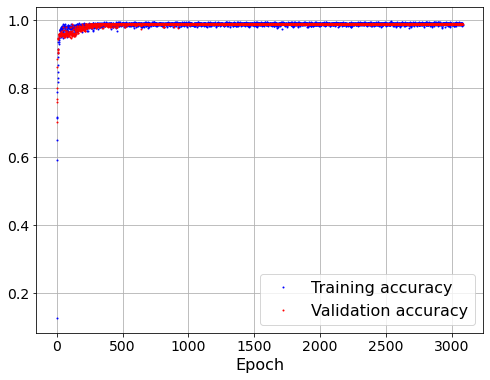

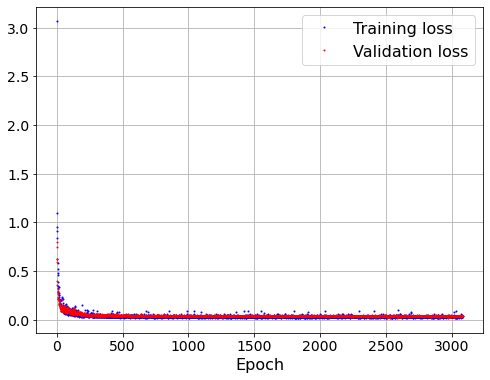

In [41]:
# Here we print the loss and accuracy
epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, "b.", markersize=2, label="Training accuracy")
plt.plot(epochs, val_acc, "r.", markersize=2, label="Validation accuracy")
# plt.title("Training and validation accuracy",fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, "b.", markersize=2, label="Training loss")
plt.plot(epochs, val_loss, "r.", markersize=2, label="Validation loss")
# plt.title("Training and validation loss",fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=16)
plt.show()

### Accuracy with the validation set

In [42]:
print(f"Validation acc: {transformer.evaluate(val_dataset)[1]:.3f}")

1/1 [==============================] - 0s 23ms/step - loss: 0.0356 - accuracy: 0.9894
Validation acc: 0.989


### Saving the model

#### Saving only the weights

In [43]:
transformer.save_weights('Transformer_v8.2_weights.h5', overwrite=True, save_format='h5', options=None)

#### Saving the entire model

In [44]:
# H5 FORMAT
transformer.save('Transformer_v8.2_model.h5',
        overwrite=True,include_optimizer=False,save_format='h5',signatures=None,options=None)
# tf FORMAT (do not use, Keras still has problems with it)
# transformer.save('Transformer_v8.0_model.tf',
#         overwrite=True,include_optimizer=False,save_format='tf',signatures=None,options=None)

#### Loading the saved model

#### Entire model (use only h5 serialization, and then recompile!)

In [47]:
# transformer = keras.models.load_model(
#     "Transformer_v8.0_model.h5",
#     custom_objects={"TransformerEncoder": TransformerEncoder,
#                     "TransformerDecoder": TransformerDecoder,
#                     "PosEmbedding": PosEmbedding}) 

# transformer.compile(optimizer="adam", 
#                     loss="sparse_categorical_crossentropy", 
#                     metrics=["accuracy"])
# transformer.summary()

#### Only the weights (best loading method after recompiling the model)

In [48]:
# transformer.load_weights('Transformer_v8.0_weights.h5')

#### Check that prediction accuracy with the validation set has not changed using the saved model

In [49]:
# print(f"Validation acc: {transformer.evaluate(val_dataset)[1]:.3f}")

#### Preparing a generic basin frame for prediction

In [50]:
# # The following shows how the input is being modified during prediction by adding
# # a new frame with only a 'start of sequence' = 4, and the rest as padding
# input_frames = np.expand_dims(inputs_trj_basins_padded_1[-1:],axis=0)
# print(input_frames.shape,type(input_frames),input_frames.dtype)

# input1 = input_frames[0][0][:-3]
# input1 = ' '.join(map(str,input1))
# print(f'Input {input_frames.shape}:\n\n{input1}\n\n')

# decoded_sentence = (np.ones((215,))*6).astype('int32')
# decoded_sentence[0] = 4
# decoded_sentence = np.expand_dims(decoded_sentence,axis=(0,1))
# print(decoded_sentence.shape)
# input_sentence = np.concatenate((input_frames,decoded_sentence),axis=1)

# print(input_sentence.shape,type(input_sentence),input_sentence.dtype)

# input1_2 = input_sentence[0][0][:]
# input2_2 = input_sentence[0][1][:]

# input1_2 = ' '.join(map(str,input1_2))
# input2_2 = ' '.join(map(str,input2_2))
# print(f'Input {input_sentence.shape}:\n\n{input1_2}\n\n{input2_2}\n\n')

In [45]:
# Function to recursively predict the next position in the frame sequence from
# the previous ones already calculated

def predict_frame(input_sequence,model,mdsl,pad,startpad,endpad):
    decoded_sequence = (np.ones((mdsl,))*pad).astype('int32')
    decoded_sequence[0] = startpad
    decoded_sequence = np.expand_dims(decoded_sequence,axis=0)    
    end = np.array([endpad]).astype('int32')
    for i in range(mdsl):
        input_sequence_2 = [input_sequence,decoded_sequence] 
        prediction = model(input_sequence_2)
        sampled_token = np.argmax(prediction[0, i, :])
        if i+1 > mdsl:
            break
        decoded_sequence[:,i+1] = sampled_token
        if sampled_token == end:
            break            
     
    return decoded_sequence

### Hand calculation of predictions with the validation set

In [52]:
# # Validation set predictions

# n_frames = len(val_inputs1)
# predicted_frames_list = []
# diff_pred_target_pos_list = []
# diff_pred_target_list = []
# diff_pred_target_cum = 0.
# diff_pred_input = 0.

# start_frame = 0
# end_frame = n_frames
# n_cycle = 0

# mdsl = 215 # max_decoded_sequence_length
# pad = 6
# startpad = 4
# endpad = 5

# for cycle,cycle_input in enumerate(zip(val_inputs1[start_frame:end_frame],val_targets[start_frame:end_frame])):
#     n_cycle += 1
    
#     # Input frame
#     input_frame = cycle_input[0]
    
#     # We remove all paddings from the target
#     target = cycle_input[1][:-3] 

#     # We expand the dimensions so that the input frame appears to the network as a batch
#     predicted_frame = predict_frame(np.expand_dims(input_frame,axis=0),transformer,mdsl,pad,startpad,endpad)
#     predicted_frame = np.squeeze(predicted_frame)
    
#     # We remove all paddings from the prediction
#     predicted_frame = predicted_frame[1:-2].astype('int32')
#     predicted_frames_list.append([predicted_frame])
    
#     # Difference between the previous and current prediction
#     if cycle == 0:
#         previous_predicted_frame = np.copy(predicted_frame)
#     diff_previous_current_pred_ind = previous_predicted_frame!=predicted_frame
#     diff_previous_current_pred = sum(diff_previous_current_pred_ind)    
#     print(f'Frame {cycle}')
#     print(f'Current prediction vs previous      (number of positions): {diff_previous_current_pred}')

#     # Difference between the current prediction and the target    
#     diff_pred_target_ind = target!=predicted_frame    
#     diff_pred_target_pos = np.where(diff_pred_target_ind[0])[0]
#     diff_pred_target_pos_list.append([diff_pred_target_pos])
#     diff_pred_target = sum(diff_pred_target_ind)
#     diff_pred_target_list.append(diff_pred_target)
#     diff_pred_target_cum += diff_pred_target
    
#     # print(f'Frame {cycle}')
#     print(f'Current prediction vs target        (number of positions): {diff_pred_target}')
#     # print(f'Cumulative predictions vs targets (fraction of positions): {diff_pred_target_cum:.4f}')

# print(f'\nNumber of frames in the validation set:     {n_cycle}')
# print(f'Number of sequence positions in each frame: {sequence_length}')
# print(f'Transformer Validation Accuracy:            {1.0-(diff_pred_target_cum/(sequence_length*n_cycle)):.4f}')    

### Trajectory extension

Rapid convergence on a sequence that remains unchanged in the following extension cycles is avoided by introducing entropy in the prediction. In this case, instead of taking the peak of the probability distribution for the next predicted basin symbol, we accept a lower than maximum value. The higher the temperature we select in the 'sample_next' function, the higher the entropy of the prediction, so that lower than maximum values of the probability distribution of the 4 symbols are taken. 

In [46]:
def sample_next(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return probas

def predict_frame_with_entropy(input_sequence,
                               model,mdsl,
                               pad,startpad,
                               endpad,
                               temperature):
    
    # global variables declared for debugging purpose
    # global decoded_sequence, sampled_token
    
    decoded_sequence = (np.ones((mdsl,))*pad).astype('int32')
    decoded_sequence[0] = startpad
    decoded_sequence = np.expand_dims(decoded_sequence,axis=0)    
    end = np.array([endpad]).astype('int32')
    for i in range(mdsl):
        input_sequence_2 = [input_sequence,decoded_sequence] 
        prediction = model(input_sequence_2)
        next_token = sample_next(prediction[0, i, :],temperature)
        sampled_token = np.argmax(next_token)
        # if i+1 > mdsl:
        if i+1 == mdsl:
            break        
        decoded_sequence[:,i+1] = sampled_token
        if sampled_token == end:
            break            

    return decoded_sequence    

#### Trajectory extension from an initial  frame of basins: example 1

We choose a frame from the validation trajectory of basins. 

In [47]:
# Choose a frame from the validation trajectory of basins. This vector of basins 
# is used to extend the trajectory of basins. 

input_basin_frame_number = 96

input_frame = np.concatenate((val_basins[input_basin_frame_number],[6,6,6]),axis=0)
print(input_frame.shape)
print(*input_frame)
print(*input_frame[:-3])

(99,)
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 6 6 6
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1


In [48]:
# Here we extend the trajectory from the input frame. 
extended_trj_basins_transformer = []
n_extensions = 100 
temperature = 1.5 # default = 1.5

mdsl = 99 # max_decoded_sequence_length
pad = 6
startpad = 4
endpad = 5

# We need to expand the dimensions so that the input appears to the network as a batch
# input_frame = val_inputs1[input_frame_number]
input_frame = np.expand_dims(input_frame,axis=0)

cycle = 1
frame_number = 1
while cycle <= n_extensions:
   
    # Predict next frame and strip all padding
    next_frame = predict_frame_with_entropy(input_frame,
                                            transformer,
                                            mdsl,
                                            pad,
                                            startpad,
                                            endpad,
                                            temperature)
    next_frame = np.squeeze(next_frame)
    next_frame = next_frame[1:-2].astype('int32')
    
    extended_trj_basins_transformer.append(next_frame)

    # Strip new_input padding 
    input_frame = np.squeeze(input_frame)
    input_frame = input_frame[:-3]    
    
    print(f'Input frame {frame_number} {input_frame.shape}:')
    print(*input_frame)
    print(f'Predicted frame {next_frame.shape}:')
    print(*next_frame)    

    # Identify different positions between input and predicted frame
    diff_ind = input_frame!=next_frame    
    diff_ind_pos = np.where(diff_ind)[0]    
    next_frame_marked = np.copy(next_frame) 
    next_frame_marked[diff_ind] = 8
    
    print(f'Predicted frame marked for differences at positions: ', [*diff_ind_pos])
    print(*next_frame_marked,'\n')    

    # The predicted frame becomes the new input
    next_frame = np.concatenate((next_frame,[6,6,6]),axis=0)
    next_frame = np.expand_dims(next_frame,axis=0)
    input_frame = next_frame

    # Check for frames having low probability basin or termination symbols (s>3). 
    # If this occurs, update only the frame number    
    if np.max(next_frame[0][:-3]) > 3:        
        print(f'Extension error at frame {frame_number}')
        frame_number += 1
    else:
        frame_number += 1
        cycle += 1
       

Input frame 1 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame marked for differences at positions:  [83]
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 8 0 0 1 1 1 1 1 1 1 0 0 1 

Input frame 2 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0

Input frame 13 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 3 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame marked for differences at positions:  [16, 45, 69, 83]
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 8 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 8 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 8 1 1 1 1 1 1 1 1 1 1 1 0 0 8 0 0 1 1 1 1 1 1 1 0 0 1 

Input frame 14 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1

Input frame 25 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame marked for differences at positions:  [39, 45, 83]
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 1 0 0 1 1 8 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 8 0 0 1 1 1 1 1 1 1 0 0 1 

Input frame 26 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

Input frame 37 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame marked for differences at positions:  [45]
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 8 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 

Input frame 38 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1

Input frame 49 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 3 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 3 0 1 1 1 1 1 1 1 0 0 1
Predicted frame marked for differences at positions:  [45, 82, 83]
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 8 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 8 8 3 0 1 1 1 1 1 1 1 0 0 1 

Input frame 50 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 3 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

Input frame 61 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 3 0 1 1 1 1 1 1 1 0 0 1
Predicted frame marked for differences at positions:  [83, 84]
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 8 8 0 1 1 1 1 1 1 1 0 0 1 

Input frame 62 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 3 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

Input frame 73 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 3 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 3 0 1 1 1 1 1 1 1 0 0 1
Predicted frame marked for differences at positions:  [69]
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 8 1 1 1 1 1 1 1 1 1 1 1 0 0 1 3 0 1 1 1 1 1 1 1 0 0 1 

Input frame 74 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 3 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1

Input frame 85 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 3 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 3 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 3 0 1 1 1 1 1 1 1 0 0 1
Predicted frame marked for differences at positions:  [16, 45]
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 8 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 8 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 3 0 1 1 1 1 1 1 1 0 0 1 

Input frame 86 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 3 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 3 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

Input frame 97 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 3 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame marked for differences at positions:  [84]
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 8 0 1 1 1 1 1 1 1 0 0 1 

Input frame 98 (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1
Predicted frame (96,):
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1

In [49]:
# Extended frames. This selection only contains the frames without not 
# allowed symbols (symbols > 3)
valid_i = 1
for i in range(len(extended_trj_basins_transformer)):
    if np.max(extended_trj_basins_transformer[i]) > 3:
        continue

    print(f'Predicted Frame {valid_i} :')
    print(*extended_trj_basins_transformer[i])
    valid_i += 1

Predicted Frame 1 :
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1
Predicted Frame 2 :
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1
Predicted Frame 3 :
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1
Predicted Frame 4 :
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1
Predicted Frame 5 :
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 3 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 

In [50]:
# Convert basin trajectory into angle trajectory using centroids
extended_trj_phipsi_from_basins = []
for i,frame in enumerate(extended_trj_basins_transformer):
    frame = np.squeeze(frame)
    if np.max(frame)>3:
        continue
    single_frame_phi_psi = []
    for j,basin in enumerate(frame):
        if basin>3:
            print(i,j,basin)
            print(*frame)
            break
        
        phi_psi = val_centroids[basin]
        single_frame_phi_psi.append(phi_psi.tolist())
        single_frame_phi_psi_ndarray = np.array(single_frame_phi_psi)
    extended_trj_phipsi_from_basins.append(single_frame_phi_psi_ndarray)

extended_trj_phipsi_from_basins = np.array(extended_trj_phipsi_from_basins)

print(extended_trj_phipsi_from_basins.shape)
print(extended_trj_phipsi_from_basins[0])

# Convert degrees to radians
deg_to_rad = np.pi/180.
extended_trj_phipsi = extended_trj_phipsi_from_basins * deg_to_rad

# Here we check the reshaping was correct
print(extended_trj_phipsi.shape)
print(extended_trj_phipsi[0])

(100, 96, 2)
[[-105.6538527   140.47328877]
 [-105.6538527   140.47328877]
 [-105.6538527   140.47328877]
 ...
 [-105.6538527   140.47328877]
 [-105.6538527   140.47328877]
 [ -70.15544119  -29.72631206]]
(100, 96, 2)
[[-1.8440076   2.4517214 ]
 [-1.8440076   2.4517214 ]
 [-1.8440076   2.4517214 ]
 ...
 [-1.8440076   2.4517214 ]
 [-1.8440076   2.4517214 ]
 [-1.22444344 -0.51882202]]


#### Conversion of the extended trajectory frame to Modeller format
This conversion requires substituting with MDAnalysis all the CD atoms of ILE to CD1 and the O1,O2 atoms of the last residue to O and OXT.

#### Check that Modeller correctly implements dihedral restraints

In [51]:
# Convert the basins of the the validation frame selected to start 
# extension into phi-psi angles in radians 

u_val_0_basins = val_basins[input_basin_frame_number]
print(*u_val_0_basins)

u_val_0_phipsi_radians = []
for basin in u_val_0_basins:
    phi_psi = val_centroids[basin]*deg_to_rad
    u_val_0_phipsi_radians.append(phi_psi.tolist())
u_val_0_phipsi_radians = np.array(u_val_0_phipsi_radians)

0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1


In [52]:
print(val_centroids)

[[-105.6538527   140.47328877]
 [ -70.15544119  -29.72631206]
 [  76.63546093    7.64436906]
 [  52.54251446   54.1126937 ]]


In [53]:
print(*u_val_0_phipsi_radians[:10])

[-1.8440076  2.4517214] [-1.8440076  2.4517214] [-1.8440076  2.4517214] [-1.8440076  2.4517214] [-1.8440076  2.4517214] [-1.8440076  2.4517214] [-1.22444344 -0.51882202] [-1.22444344 -0.51882202] [-1.22444344 -0.51882202] [-1.22444344 -0.51882202]


In [75]:
# using MDAnalysis write out without hydrogens the input frame 
# from the 'protein' validation trajectory 

# This frame does not have to be the same frame selected to start the basin
# extension. 

# The protein conformation in this frame will be the starting point,
# u_val.pdb, to apply the consecutive phi-psi angle changes.

# For example, we expanded the 'basin' trj using validation basin
# frame number 96, but we select validation protein frame number 48 
# as the starting point to generate a 'protein' extended trj

#input_protein_frame_number = 48
input_protein_frame_number = 10

u_val.trajectory[input_protein_frame_number]
u_val_0_protein = u_val.select_atoms('resid 1:85 and not (name H* )')

with mda.Writer("ua_val.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein) 
    
u_val_0 = mda.Universe('ua_val.pdb','ua_val.pdb')

u_val_0_protein = u_val_0.select_atoms('resid 1:85 and not (name H* )')

# Change chainid to 'A'
for atom_ind in range(len(u_val_0_protein)): 
    u_val_0.atoms[atom_ind].chainID = 'A'

n_res = len(u_val_0_protein.residues)

# If necessary, we shift all atoms into the unit cell
# u_val_0_protein.pack_into_box(box=None, inplace=True)

# Change HSD to HIS
HSD_ATOMS = u_val_0_protein.select_atoms('resname HSD')
for atom_ind in range(len(HSD_ATOMS)):
    HSD_ATOMS.atoms[atom_ind].residue.resname = 'HIS'
    
# Change Isoleucine CD to CD1
ILE_CD_ATOMS = u_val_0_protein.select_atoms('resname ILE and (name CD)')
for atom_ind in range(len(ILE_CD_ATOMS)):
    ILE_CD_ATOMS.atoms[atom_ind].name = 'CD1'

# Change CTERM atoms O1,O2 to O and OXT
lastresnum = 'resnum ' + str(len(u_val_0_protein.residues))
CTERM_ATOMS = u_val_0_protein.select_atoms(lastresnum)
CTERM_ATOMS[-2].name = 'O'
CTERM_ATOMS[-1].name = 'OXT'

with mda.Writer("ua_val_0.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein)    

In [76]:
# using MDAnalysis write out without hydrogens the input frame 
# from the 'protein' validation trajectory 

# This frame does not have to be the same frame selected to start the basin
# extension. 

# The protein conformation in this frame will be the starting point,
# u_val.pdb, to apply the consecutive phi-psi angle changes.

# For example, we expanded the 'basin' trj using validation basin
# frame number 96, but we select validation protein frame number 48 
# as the starting point to generate a 'protein' extended trj

#input_protein_frame_number = 48
input_protein_frame_number = 10

u_val.trajectory[input_protein_frame_number]
u_val_0_protein = u_val.select_atoms('resid 86:98 and not (name H* )')

with mda.Writer("ub_val.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein) 
    
u_val_0 = mda.Universe('ub_val.pdb','ub_val.pdb')

u_val_0_protein = u_val_0.select_atoms('resid 86:98 and not (name H* )')

# Change chainid to 'A'
for atom_ind in range(len(u_val_0_protein)): 
    u_val_0.atoms[atom_ind].chainID = 'B'

n_res = len(u_val_0_protein.residues)

# If necessary, we shift all atoms into the unit cell
# u_val_0_protein.pack_into_box(box=None, inplace=True)

# Change HSD to HIS
HSD_ATOMS = u_val_0_protein.select_atoms('resname HSD')
for atom_ind in range(len(HSD_ATOMS)):
    HSD_ATOMS.atoms[atom_ind].residue.resname = 'HIS'
    
# Change Isoleucine CD to CD1
ILE_CD_ATOMS = u_val_0_protein.select_atoms('resname ILE and (name CD)')
for atom_ind in range(len(ILE_CD_ATOMS)):
    ILE_CD_ATOMS.atoms[atom_ind].name = 'CD1'

# Change CTERM atoms O1,O2 to O and OXT
lastresnum = 'resnum ' + str(len(u_val_0_protein.residues))
CTERM_ATOMS = u_val_0_protein.select_atoms(lastresnum)
#CTERM_ATOMS[-2].name = 'O'
#CTERM_ATOMS[-1].name = 'OXT'

with mda.Writer("ub_val_0.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein)    

In [77]:
# After converting HSD to HIS, write out again the sequence in 1 letter code

# Protein sequence in 3 letter code
prot_sequence_tlc = ''
for res in chain.from_iterable(u_val_0_protein.residues.resnames):
    prot_sequence_tlc += res
# print(f'Protein sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc.append(prot_sequence_tlc[index : index + n])
# print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc}\n')

# Protein sequence in 3 letter code
prot_sequence_slc = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc}')

Protein sequence in 1 letter code:
ETFSDLWKLLPEN


#### Modeller environment

In [78]:
# Initial alignment

sequence = prot_sequence_slc + '*'

with open("alignment.ali", "w") as text_file:
    print(f'>P1;orig\nstructureX:u_val_0.pdb:1:A:{n_res}:A::::\n{sequence}',file=text_file)
    print(f'>P1;seq\nsequence::1:A:{n_res}:A::::\n{sequence}',file=text_file)
    

In [98]:
# Initial minimization of the reference structure with phi-psi constraints

log.level(output=0, notes=0, warnings=0, errors=0, memory=0)
env = Environ()
env.io.atom_files_directory = '.'
env.edat.dynamic_sphere = True

env.libs.topology.read(file='$(LIB)/top_heav.lib')
env.libs.parameters.read(file='$(LIB)/par.lib')

code = 'ua_val_0'
mdl = complete_pdb(env, code + '.pdb')
# mdl.write(file = code + '.ini')
rsr = mdl.restraints

# Select all atoms:
atmsel = Selection(mdl)    

# Generate the static restraints:
rsr.make(atmsel, restraint_type='stereo', spline_on_site=False)

# Example of atoms selection for phi-psi restraints
# 2 ARG PHI:  (1 MET C)-(2 ARG N)-(2 ARG CA)-(2 ARG C)  
# 2 ARG PSI:  (2 ARG N)-(2 ARG CA)-(2 ARG C)-(3 ILE N) 

# Add dynamic restraints on the phi-psi dihedrals
for i in range(2,85): 
    phi_1 = mdl.atoms['C:'+str(i-1)+':A']
    phi_2 = mdl.atoms['N:'+str(i)+':A']
    phi_3 = mdl.atoms['CA:'+str(i)+':A']
    phi_4 = mdl.atoms['C:'+str(i)+':A']    
    psi_1 = mdl.atoms['N:'+str(i)+':A']
    psi_2 = mdl.atoms['CA:'+str(i)+':A']
    psi_3 = mdl.atoms['C:'+str(i)+':A']
    psi_4 = mdl.atoms['N:'+str(i+1)+':A']

    # Binormal constraints
    rsr.add(forms.MultiBinormal(group=physical.phi_psi_dihedral,
                           features=[features.Dihedral(phi_1, phi_2, phi_3, phi_4),
                                     features.Dihedral(psi_1, psi_2, psi_3, psi_4)],
                           weights=[100,100],
                           means=[u_val_0_phipsi_radians[i-2,:].tolist(),                                
                                  u_val_0_phipsi_radians[i-2,:].tolist()],                                
                           stdevs=[[0.1,0.1],[0.1,0.1]],
                           correls=[0.5,0.5]))    

mdl.restraints.write(file = code + '.rsr')

# Addition of restraints to the default ones
class RestrainModel(AutoModel):
    def special_restraints(self, aln):
        rsr = self.restraints
        # Add restraints from file:
        rsr.append(file = code + '.rsr')          

a = RestrainModel(env,
            alnfile  = 'alignment.ali',     # alignment filename
            knowns   = 'orig',              # codes of the templates
            sequence = 'seq',
            )              # code of the target
a.starting_model= 1                 # index of the first model
a.ending_model  = 1                 # index of the last model
                                    # (determines how many models to calculate)
a.make()                            # do comparative modeling

a.write(file='ua_val_0_min.pdb')


0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of failed models:
seq.B99990001.pdb         csrrng__299E> Atom index is out of bounds:      114      113



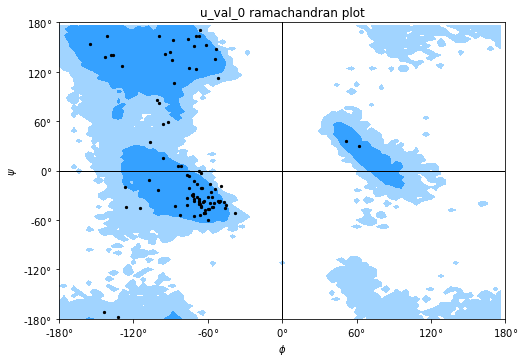

In [88]:
# Here we check that the phi=psi constraints really worked. After minimization 
# the ramachandran plot should show phi-psi angles clustered around the centroids
# To select a range of frames in a trajectory 
# use .run(startframe,endframe+1)

# Ramachandran angles in the reference protein. 
u_val_0 = mda.Universe('u_val_0.pdb','u_val_0.pdb')
u_val_0_protein = u_val_0.select_atoms('protein and not (name H* )')
u_val_0_rama = dihedrals.Ramachandran(u_val_0_protein).run()
plt.figure(figsize=(8, 12)) 
plt.subplot(2,1,1)
u_val_0_rama.plot(color='black', marker='.', s=20, ref=True)
plt.title('u_val_0 ramachandran plot') 
u_val_0_phipsi_obs_radians = u_val_0_rama.results.angles * deg_to_rad
# print(f'Ramachandran angles array shape: {u_val_0_phipsi.shape}')
# print(u_val_0_phipsi_radians.shape)
# print(u_val_0_phipsi_radians[0][:6])

# Ramachandran angles in the minimized reference protein. 
#u_val_0_min = mda.Universe('u_val_0_min.pdb','u_val_0_min.pdb')
#u_val_0_min_protein = u_val_0_min.select_atoms('protein and not (name H* )')
#u_val_0_min_rama = dihedrals.Ramachandran(u_val_0_min_protein).run()
#plt.subplot(2,1,2)
#u_val_0_min_rama.plot(color='black', marker='.', s=20, ref=True)
#plt.title('u_val_0_min ramachandran plot')          
#u_val_0_min_phipsi_radians = u_val_0_min_rama.results.angles * deg_to_rad
# print(f'Ramachandran angles array shape: {u_val_0_min_phipsi.shape}')
# print(u_val_0_min_phipsi_radians.shape)
# print(u_val_0_min_phipsi_radians[0][:6])

#### Comparison of initial and phi-psi constrained minimized structures

In [93]:
# Backbone rmsd between the structures
RMSD = rms.rmsd(u_val_0.select_atoms('backbone and not(name H*)').positions,  # coordinates to align
         u_val_0.select_atoms('backbone and not(name H*)').positions,  # reference coordinates
         center=True,  # subtract the center of geometry
         superposition=True)  # superimpose coordinates
print(f'RMSD[backbone] (u_val_0 vs. u_val_0): {RMSD:.3f}')

# Superposition before and after minimization
rmsds = align.alignto(u_val_0,  # minimized
                      u_val_0,  # reference
                      select='name CA', # selection to operate on
                      match_atoms=True) # whether to match atoms
print(rmsds)
nv.show_mdanalysis(mda.Merge(u_val_0.atoms, u_val_0.atoms))

RMSD[backbone] (u_val_0 vs. u_val_0): 0.000
(0.0, 0.0)


NGLWidget()

In [118]:
ppi_ref = mda.Universe('ppcomplex.pdb','ppcomplex.pdb')
# Backbone rmsd between the structures
RMSD = rms.rmsd(u_val_0.select_atoms('backbone and not(name H*)').positions,  # coordinates to align
         ppi_ref.select_atoms('backbone and not(name H*)').positions,  # reference coordinates
         center=True,  # subtract the center of geometry
         superposition=True)  # superimpose coordinates
print(f'RMSD[backbone] (u_val_0 vs. ppi_ref): {RMSD:.3f}')

# Superposition before and after minimization
rmsds = align.alignto(u_val_0,  # minimized
                      ppi_ref,  # reference
                      select='name CA', # selection to operate on
                      match_atoms=True) # whether to match atoms
print(rmsds)
nv.show_mdanalysis(mda.Merge(u_val_0.atoms, ppi_ref.atoms))

RMSD[backbone] (u_val_0 vs. ppi_ref): 1.275
(17.753231374238307, 1.2156379364579364)


NGLWidget()